In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

import numpy as np
import PIL
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import zscore

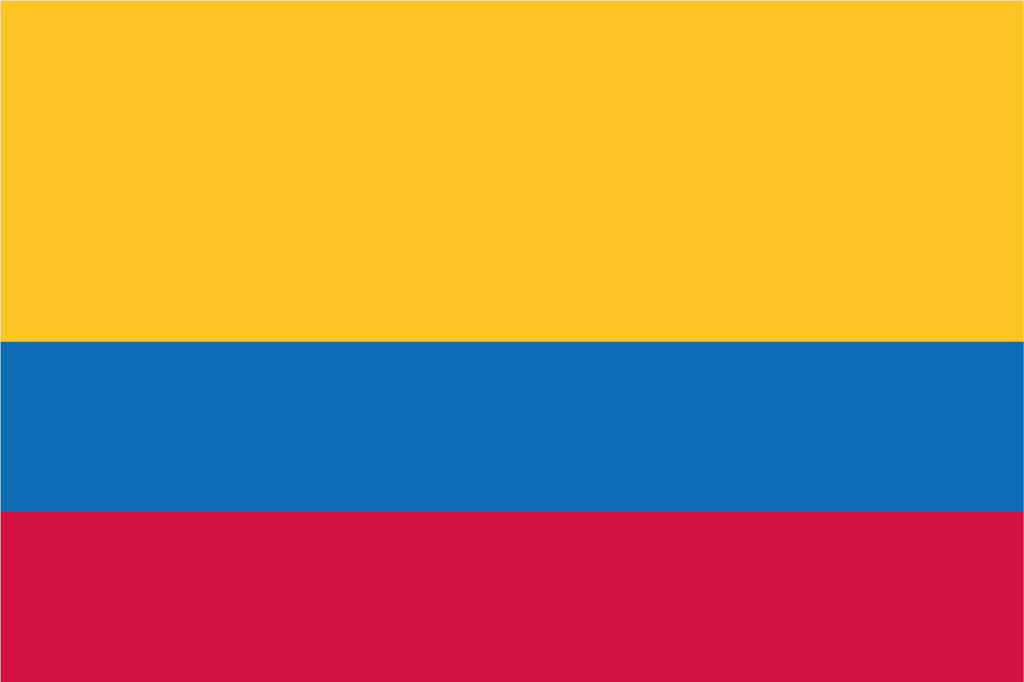

In [3]:
# testing

## to display an image from disk
from IPython.display import Image 

Image('flags/colombia.jpg')

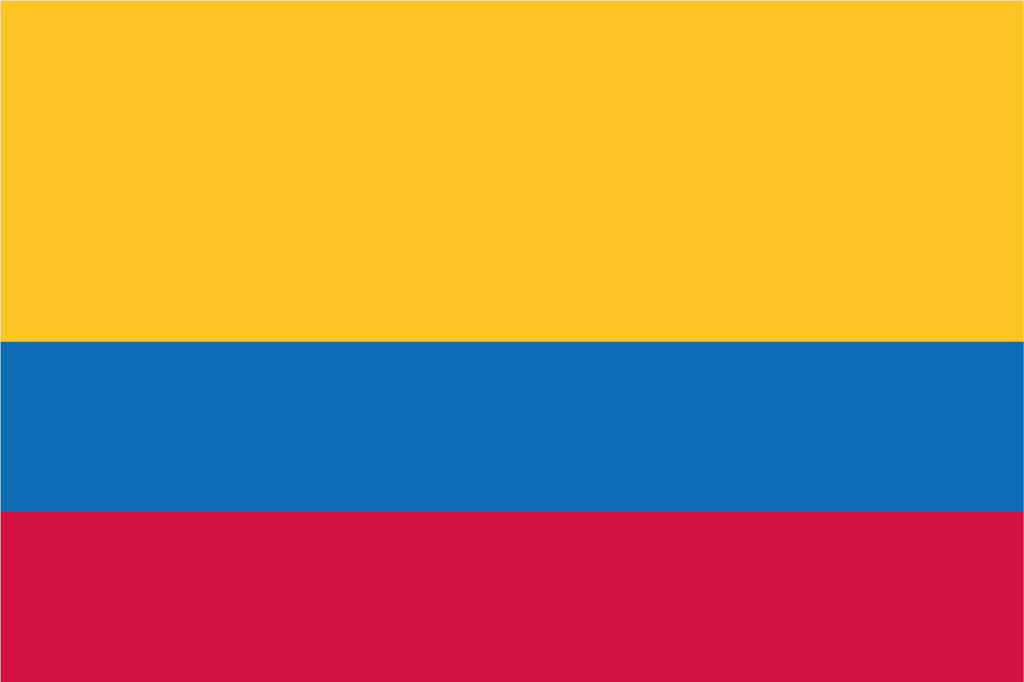

In [4]:
## to display an array as an image
colombia_bitmap = imread('flags/colombia.jpg')
PIL.Image.fromarray(colombia_bitmap)

# Import flag bitmaps as numpy arrays

In [5]:
flag_bitmaps = []

for flag in glob.glob('flags/*.jpg'):
    flag_bitmaps.append( imread(flag) )

# Normalize data

## Resize all flags to the proportions of the largest bounding box

In [6]:
flag_bitmap_shapes = [bitmap.shape for bitmap in flag_bitmaps]

max_first_dimension = max([shape[0] for shape in flag_bitmap_shapes])
max_second_dimension = max([shape[1] for shape in flag_bitmap_shapes])
max_third_dimension = max([shape[2] for shape in flag_bitmap_shapes])

max_bounding_box = (max_first_dimension, max_second_dimension, max_third_dimension)
print('Max bounding box: ({}, {}, {})'.format(*max_bounding_box))

Max bounding box: (684, 1025, 3)


In [7]:
reduced_max_bounding_box = (68, 102, 3)
print('Reduced size bounding box ({}, {}, {})'.format(*reduced_max_bounding_box))

Reduced size bounding box (68, 102, 3)


In [8]:
resized_flag_bitmaps = [imresize(bitmap, size=reduced_max_bounding_box) for bitmap in flag_bitmaps]

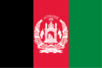

In [9]:
PIL.Image.fromarray(resized_flag_bitmaps[0])

## Scale images to [0, 1], flatten images, then create an input matrix

In [10]:
input_matrix = np.array([bitmap.flatten() / 255. for bitmap in resized_flag_bitmaps])

# Instantiate network

In [11]:
from vanilla_neural_nets.autoencoder.sparse_autoencoder.network import VanillaSparseAutoencoder
from vanilla_neural_nets.neural_network.training_batch_generator import MiniBatchGenerator
from vanilla_neural_nets.autoencoder.sparse_autoencoder.optimization_algorithm import SparsityEnforcingGradientDescent
from vanilla_neural_nets.autoencoder.sparse_autoencoder.loss_function import SparseMeanSquaredError, KLDivergenceSparsityLoss
from vanilla_neural_nets.neural_network.activation_function import SigmoidActivationFunction
from vanilla_neural_nets.neural_network.parameter_initialization import GaussianWeightInitializer, GaussianBiasInitializer

In [12]:
N_HIDDEN_UNITS = 64
N_SAMPLES = input_matrix.shape[0]
N_FEATURES = input_matrix.shape[1]
LAYER_SIZES = [N_FEATURES, N_HIDDEN_UNITS, N_FEATURES]

In [26]:
LEARNING_RATE = .05
TRAINING_BATCH_SIZE = 72
N_EPOCHS = 1000
RANDOM_STATE = 123
RHO = .05
BETA = .25
GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION = 1. / np.sqrt(N_FEATURES)

In [27]:
training_set = input_matrix[:100, :]
validation_set = input_matrix[100:120, :]
test_set = input_matrix[120:, :]

In [28]:
class VanillaSparseAutoencoderWithLogging(VanillaSparseAutoencoder):
    
    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            training_batch_generator = self.training_batch_generator_class(X=X, y=y, batch_size=self.training_batch_size,
                random_number_generator=self.random_number_generator)

            for training_batch in training_batch_generator:
                self.parameters = self._update_network_layers_with_training_batch(training_batch)
                
            if epoch % 25 == 0:
                print('Epoch: {}'.format(epoch))
                print('Training Loss: {}'.format( self._compute_loss(X=X, y=y)) )
                print('Validation Loss: {}'.format( self._compute_loss(X=validation_set, y=validation_set)) )
                print('Test Loss: {}'.format( self._compute_loss(X=test_set, y=test_set)) )
            
    def _compute_loss(self, X, y):
        predictions, mean_hidden_layer_activations = self.predict(X)
        loss = self.loss_function_class.loss(
            y_true=y,
            y_predicted=predictions,
            rho=RHO,
            vector_of_rho_hats=mean_hidden_layer_activations,
            beta=BETA
        )
        if np.isinf(loss).sum() > 0:
            from IPython.core.debugger import Tracer; Tracer()()
        return loss

In [29]:
network = VanillaSparseAutoencoderWithLogging(
    layer_sizes=LAYER_SIZES,
    training_batch_generator_class=MiniBatchGenerator,
    loss_function_class=SparseMeanSquaredError,
    activation_function_class=SigmoidActivationFunction,
    optimization_algorithm_class=SparsityEnforcingGradientDescent,
    sparsity_constraint_class=KLDivergenceSparsityLoss,
    learning_rate=LEARNING_RATE,
    n_epochs=N_EPOCHS,
    training_batch_size=TRAINING_BATCH_SIZE,
    random_state=RANDOM_STATE,
    rho=RHO,
    beta=BETA,
    weight_initializer=GaussianWeightInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    ),
    bias_initializer=GaussianBiasInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    )
)

# Train

In [30]:
network.fit(X=training_set, y=training_set)

Epoch: 0
Training Loss: 1486.3847668880712
Validation Loss: 1485.1386814293521
Test Loss: 1472.3265468095983
Epoch: 25
Training Loss: 1249.2448622674483
Validation Loss: 1341.0245739334825
Test Loss: 1279.0018358725622
Epoch: 50
Training Loss: 1057.1191530844544
Validation Loss: 1232.86206466118
Test Loss: 1155.2801089214252
Epoch: 75
Training Loss: 967.057231628783
Validation Loss: 1176.9478495655026
Test Loss: 1110.016263958894
Epoch: 100
Training Loss: 897.3655751542308
Validation Loss: 1132.988438549415
Test Loss: 1073.2778093443571
Epoch: 125
Training Loss: 831.3963941274901
Validation Loss: 1084.491284423306
Test Loss: 1038.3474706756247
Epoch: 150
Training Loss: 783.1074703478839
Validation Loss: 1061.1282181131617
Test Loss: 1010.6965274084168
Epoch: 175
Training Loss: 734.6826253184481
Validation Loss: 1027.6479892677903
Test Loss: 985.1755355132254
Epoch: 200
Training Loss: 700.3616502010142
Validation Loss: 997.5597248741249
Test Loss: 964.9480718610434
Epoch: 225
Training L

/Users/willwolf/Documents/willwolf/vanilla-neural-nets/vanilla_neural_nets/neural_network/activation_function.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-linear_combination))


Epoch: 450
Training Loss: 532.7882006224792
Validation Loss: 875.0629907074981
Test Loss: 902.1157012750115
Epoch: 475
Training Loss: 520.8053282640773
Validation Loss: 868.7253336832441
Test Loss: 897.8225255269875
Epoch: 500
Training Loss: 505.8767379428085
Validation Loss: 863.7835193837271
Test Loss: 894.0602011593345
Epoch: 525
Training Loss: 502.9754980917399
Validation Loss: 864.9031147433091
Test Loss: 887.1756337628262
Epoch: 550
Training Loss: 513.9576156658278
Validation Loss: 848.8604409434554
Test Loss: 888.0735615218127
Epoch: 575
Training Loss: 483.367316652998
Validation Loss: 827.8323232140903
Test Loss: 882.1764877169488
Epoch: 600
Training Loss: 476.94351425816
Validation Loss: 825.4915238088598
Test Loss: 874.9278943315045
Epoch: 625
Training Loss: 466.78017808698235
Validation Loss: 842.1453414373746
Test Loss: 879.8210728087336
Epoch: 650
Training Loss: 461.3003327199477
Validation Loss: 817.3124847834623
Test Loss: 891.8628300326404
Epoch: 675
Training Loss: 466.

In [31]:
image_index = 0

In [32]:
reshaped_original = (input_matrix[image_index].reshape(*reduced_max_bounding_box) * 255).astype(np.uint8)

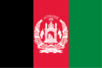

In [33]:
PIL.Image.fromarray(reshaped_original)

In [35]:
predictions, hidden_layer_activations = network.predict(input_matrix[image_index])

In [36]:
predictions_reshaped = (predictions.reshape(*reduced_max_bounding_box) * 255).astype(np.uint8)

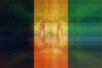

In [37]:
PIL.Image.fromarray(predictions_reshaped)

In [39]:
generated_predictions = network.generate(hidden_layer_activations)

In [41]:
generated_predictions.shape

(64, 20808)

In [40]:
generated_predictions_reshaped = (generated_predictions.reshape(*reduced_max_bounding_box) * 255).astype(np.uint8)

ValueError: total size of new array must be unchanged

In [ ]:
predictions, hidden_layer_activations = network.predict(training_set[0])

In [ ]:
hidden_layer_activations.shape